# Test Architecture

We check that our stability training architecture is working expectedly with perturbed image packing and unpacking.

## Experiment

We import useful librairies

In [64]:
import tensorflow as tf
import sys, os 
sys.path.append(os.getcwd()+'/../src')
sys.path.append(os.getcwd()+'/../data')

import numpy
import matplotlib.pyplot as plt
% matplotlib inline
from IPython.display import clear_output
numpy.set_printoptions(threshold=numpy.nan)

import architectures
import cifar10
import utils

We retrieve data:

In [46]:
X_train, y_train_lab = cifar10.load_cifar(dataset='training', path=os.getcwd()+'/../data/cifar')
X_train = numpy.reshape(X_train, [X_train.shape[0], -1])
X_train = X_train/255.
X_train.astype(numpy.float32)
y_train = utils.labels_to_categoricals(y_train_lab)

X_test, y_test_lab = cifar10.load_cifar(dataset='testing', path=os.getcwd()+'/../data/cifar')
X_test = numpy.reshape(X_test, [X_test.shape[0], -1])
X_test = X_test/255.
X_test = X_test.astype(numpy.float32)
y_test = utils.labels_to_categoricals(y_test_lab)

We check that the data is in expected shape

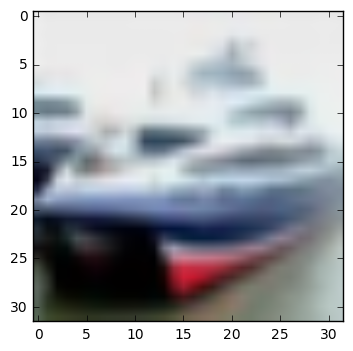

In [49]:
plt.imshow(numpy.reshape(X_test[1], [32,32,3]))

We define the architecture of the network

In [69]:
# Define Network # =========================================================================================

# Input # --------------------------------------------------------------------------------------------------
net_input = tf.placeholder(tf.float32, shape=[None, 32 * 32 * 3])
x_image = tf.reshape(net_input, [-1, 3, 32, 32])

# Perturbing # ---------------------------------------------------------------------------------------------
# We create perturation
stdv = 0.05
prtrb = tf.random_normal(tf.shape(x_image), stddev=stdv, dtype=tf.float32)
# We perturb image
x_prtrb = tf.add(x_image, prtrb)
# We pack perturbed and unperturbed images into a single input tensor
x_image = tf.expand_dims(x_image, axis=1)
x_prtrb = tf.expand_dims(x_prtrb, axis=1)
x = tf.pack([x_image,x_prtrb], axis=1)
x = tf.reshape(x,[-1,32,32,3])
x_sp = tf.reshape(x, [-1,2,32,32,3])
x_sp1,x_sp2= tf.split(1, 2, x_sp)

# Conv1 # --------------------------------------------------------------------------------------------------
W1 = tf.Variable(tf.truncated_normal([5, 5, 3, 64], stddev=0.05), dtype=tf.float32)
b1 = tf.Variable(tf.constant(0.1, shape=[64]), dtype=tf.float32)
a1 = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='SAME')
a1 = tf.add(a1, b1)
a1 = tf.nn.relu(a1)
a1 = tf.nn.max_pool(a1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID')

# Conv2 # --------------------------------------------------------------------------------------------------
W2 = tf.Variable(tf.truncated_normal([5, 5, 64, 64], stddev=0.05), dtype=tf.float32)
b2 = tf.Variable(tf.constant(0.1, shape=[64]), dtype=tf.float32)
a2 = tf.nn.conv2d(a1, W2, strides=[1, 1, 1, 1], padding='SAME')
a2 = tf.add(a2, b2)
a2 = tf.nn.relu(a2)
a2 = tf.nn.max_pool(a2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID')

# Full3 # --------------------------------------------------------------------------------------------------
W3 = tf.Variable(tf.truncated_normal([7*7*64, 384], stddev=0.04), dtype=tf.float32)
b3 = tf.Variable(tf.constant(0.1, shape=[384]), dtype=tf.float32)
a3 = tf.reshape(a2, [-1, 7*7*64])
a3 = tf.add(tf.matmul(a3, W3), b3)
a3 = tf.nn.relu(a3)
a3 = tf.nn.dropout(a3,0.5)

# Full4 # --------------------------------------------------------------------------------------------------
W4 = tf.Variable(tf.truncated_normal([384, 192], stddev=0.04), dtype=tf.float32)
b4 = tf.Variable(tf.constant(0.1, shape=[192]), dtype=tf.float32)
a4 = tf.add(tf.matmul(a3, W4), b4)
a4 = tf.nn.relu(a4)
a4 = tf.nn.dropout(a4,0.5)

# Full5 # --------------------------------------------------------------------------------------------------
W5 = tf.Variable(tf.truncated_normal([192, 10], stddev=1/192), dtype=tf.float32)
b5 = tf.Variable(tf.constant(0.1, shape=[10]), dtype=tf.float32)
a5 = tf.add(tf.matmul(a4, W5), b5)

# Output # -------------------------------------------------------------------------------------------------
output = tf.nn.softmax(a5)
net_label = tf.placeholder(tf.float32, shape=[None, 10])

# Perturbation separation # --------------------------------------------------------------------------------
# We separate back the perturbed and unpuerturbed images
output = tf.reshape(output,[-1,2,10])
output_image, output_prtrb = tf.split(1, 2, output)
output_image = tf.reshape(output_image,[-1,10])
output_prtrb = tf.reshape(output_prtrb,[-1,10])

net_output = output_image

# Define Loss # ============================================================================================
# We define the alpha parameter 
alpha = 0.1
# We compute the loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(net_label * tf.log(net_output), reduction_indices=[1]))
stability_term = tf.reduce_mean(-tf.reduce_sum(output_prtrb * tf.log(output_image), reduction_indices=[1]))
loss = tf.add(cross_entropy, tf.scalar_mul(alpha, stability_term))
weights = tf.trainable_variables()
weights_decay = tf.add_n([tf.nn.l2_loss(v) for v in weights]) * 0.004
net_loss = tf.add(loss, weights_decay)

# Define Optimizer # =======================================================================================
net_optimize = tf.train.AdadeltaOptimizer(1e-3).minimize(net_loss)

# Define Accuracy # ========================================================================================
correct_prediction = tf.equal(tf.argmax(net_output, 1), tf.argmax(net_label, 1))
net_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Define Output Gradient wrt input # =======================================================================
input_grad = tf.gradients(net_output, net_input)

We instantiate Tensorflow sessions

In [70]:
# We instantiate Session object
sess = tf.InteractiveSession()
# We initialize the values
sess.run(tf.global_variables_initializer())

We check the packed samples (perturbed and unperturbed ones)

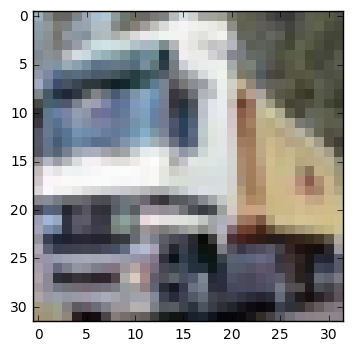

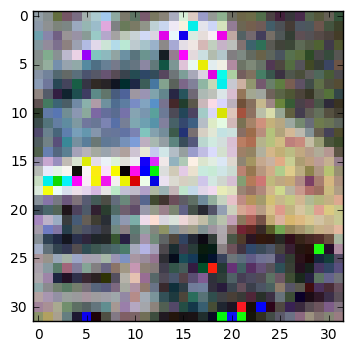

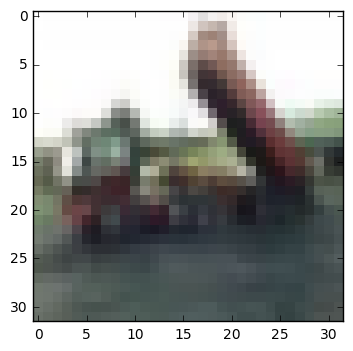

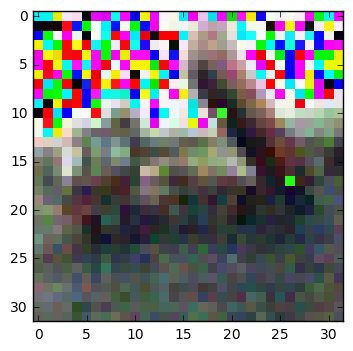

In [51]:
a = x.eval(feed_dict={net_input : X_train[1:3]})
for i in range(0,4):
    plt.imshow(numpy.reshape(a[i],[32,32,3]), interpolation='none')
    plt.show()

We show the unpacked tensors

Show First separated tensor


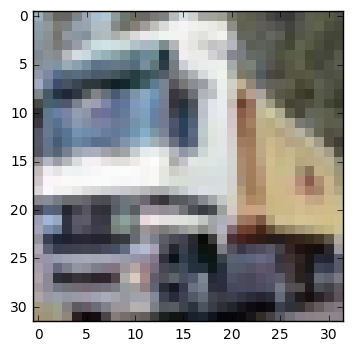

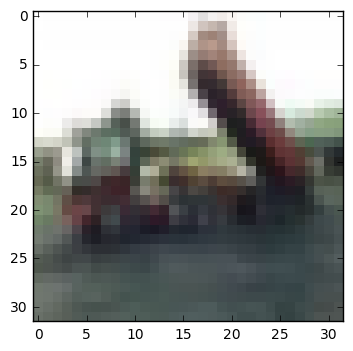

Show Second separated tensor


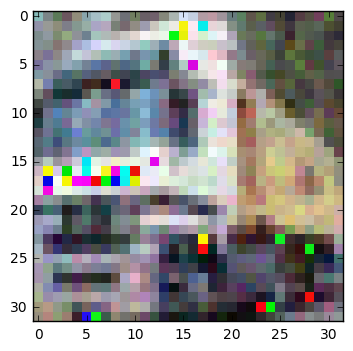

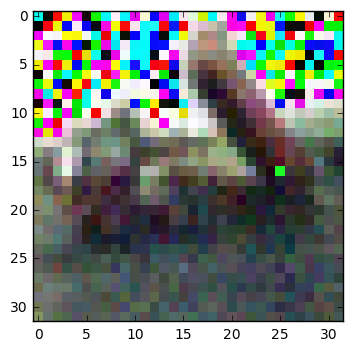

In [52]:
b = x_sp1.eval(feed_dict={net_input : X_train[1:3]})
c = x_sp2.eval(feed_dict={net_input : X_train[1:3]})

print("Show First separated tensor")
for i in range(0,2):
    plt.imshow(numpy.reshape(b[i],[32,32,3]), interpolation='none')
    plt.show()
print("Show Second separated tensor")
for i in range(0,2):
    plt.imshow(numpy.reshape(c[i],[32,32,3]), interpolation='none')
    plt.show()
    

In [200]:
d = input_grad[0].eval(feed_dict={net_output:y_train[1:3].astype(numpy.float32)})
d = numpy.sign(d[0])

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_20' with dtype float
	 [[Node: Placeholder_20 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Placeholder_20', defined at:
  File "/home/apere/anaconda3/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/apere/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/apere/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/apere/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/home/apere/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/apere/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/apere/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/apere/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/apere/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/apere/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/apere/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/apere/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/apere/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/apere/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/apere/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/apere/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/apere/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/apere/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/apere/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/apere/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-69-e6701ab47aec>", line 4, in <module>
    net_input = tf.placeholder(tf.float32, shape=[None, 32 * 32 * 3])
  File "/home/apere/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1512, in placeholder
    name=name)
  File "/home/apere/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2043, in _placeholder
    name=name)
  File "/home/apere/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/home/apere/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/apere/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_20' with dtype float
	 [[Node: Placeholder_20 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


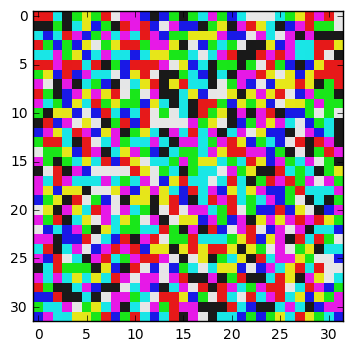

In [164]:
d = d*0.1
plt.imshow(numpy.reshape(d,[32,32,3]), interpolation='none')

In [167]:
y_train[1:3].astype(numpy.float32)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]], dtype=float32)

In [199]:
output.eval(feed_dict={net_input:X_train[1:2]})

array([[[ 0.10980564,  0.09473106,  0.09307282,  0.10461286,  0.10466037,
          0.09426462,  0.10065389,  0.09790074,  0.10389788,  0.09640012],
        [ 0.10535207,  0.09402476,  0.10023164,  0.10258219,  0.10415107,
          0.09599161,  0.10106273,  0.09110469,  0.10113927,  0.10435994]]], dtype=float32)